In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
# import squarify
import plotly.offline as py
# import plotly_express as px

# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot

In [2]:
cdata= pd.read_csv('finalDataset.csv', index_col=0)
cdata.head()

,country,sub-region,date,driving,transit,walking,Confirmed,Deaths,Recovered
0,Albania,Total,2020-01-22,-6.49,NaN,-4.61,0,0,0
1,Albania,Total,2020-01-23,-7.06,NaN,-5.76,0,0,0
2,Albania,Total,2020-01-24,2.13,NaN,-6.27,0,0,0
3,Albania,Total,2020-01-25,2.38,NaN,-2.94,0,0,0
4,Albania,Total,2020-01-26,1.41,NaN,-22.73,0,0,0


In [3]:
cdata['date'] =  pd.to_datetime(cdata['date'], infer_datetime_format=True)
cdata = cdata.set_index('date')
cdata.index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-09-14', '2020-09-15', '2020-09-15', '2020-09-15',
               '2020-09-16', '2020-09-16', '2020-09-16', '2020-09-17',
               '2020-09-17', '2020-09-17'],
              dtype='datetime64[ns]', name='date', length=252663, freq=None)

In [23]:
df = cdata.head(10)

In [5]:
confirmed_d = cdata['Confirmed'].resample('MS').mean()
deaths_d = cdata['Deaths'].resample('MS').mean()
recovered_d= cdata['Recovered'].resample('MS').mean()
driving_d= cdata['driving'].resample('MS').mean()
walking_d= cdata['transit'].resample('MS').mean()
transit_d= cdata['walking'].resample('MS').mean()

In [6]:
def scoring_rmse(y_pred, y_test):
    print(y_pred)
    print(y_test)
    rmse = np.sqrt(np.mean(np.square(y_test.values - y_pred.values)))
    return rmse

def scoring_mape(pred,test):
    try:
        mape = np.mean(np.abs((test - pred) / test))
    except:
        mape = -1
    return mape

In [7]:
def data_creation_sarima(data,division):
    """
    return
    -----------------
    split[0]: training set
    split[1]: test set
    """
    split = []
    div = division
    data.fillna(method='ffill',inplace=True)
    train_size = int(len(data) * div)
    train, test = data[0:train_size], data[train_size:len(data)]
    split.append(train)
    split.append(test)
    return(split)

In [8]:
def sarimax_modelling2(data,exog,div=0.9,max_range=1):
    seas_values = [12]
    result_list = []
    train_size = int(len(data) * div)
    min_rmse = 999999
    mape = 99999
    param = None
    seas_param = None
    train_exog,test_exog = exog[0:train_size], exog[train_size:len(data)]
    for i in seas_values:
#         try:
#             result_list.append(get_sarimax(data,train_exog,test_exog,max_range,seasonal_factor=i))
        temp_res = get_sarimax(data,train_exog,test_exog,max_range,seasonal_factor=i)
        temp_rmse = temp_res['rmse']
        if temp_rmse<min_rmse:
            min_rmse = temp_rmse
            param = temp_res['parameter']
            seas_param = temp_res['seasonal paramater']
            mape = temp_res['mape']
#         except:
#             pass
    return {'param':param,'seas_param':seas_param,'rmse':min_rmse,'mape':mape}

In [9]:
def get_sarimax(trend,exog_train,exog_test,max_range=3,seasonal_factor=12):
    #sarima modelling on trend with period = 12
    train,test = data_creation_sarima(trend,0.9)
    param_order = []
    param_seas = []
    p = d = q = range(0, max_range)
    pdq = list(itertools.product(p, d, q))

    #seasonal parameter = seasonal_factor
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_factor) for x in list(itertools.product(p, d, q))]
#     print(pdq,seasonal_pdq)
    
    min_rmse=9999999
    min_model_mape = 9999999
    min_model_aic = 9999999
    final_predictions=-1 
    result_param=-1 
    result_param_seasonal=-1
    for i in [(1,1,1)]:#range(0,len(pdq)):
        for j in [(1,0,0,12)]:#range(0,len(seasonal_pdq)):
#             try:

            param = pdq[i]
            param_seasonal = seasonal_pdq[j]
            mod = sm.tsa.statespace.SARIMAX(train,exog=exog_train,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            aic_value = results.aic
#                 if math.isnan(temp) or math.isinf(temp):
#                     temp = 999.99
            pred = results.predict(len(train),len(trend)-1,exog = exog_test)
            rmse = scoring_rmse(pred,test)
            mape = scoring_mape(pred,test)
#                 print(pred,rmse,mape)
            if rmse < min_rmse:
                min_rmse = rmse
                min_model_aic = aic_value
                min_model_mape = mape
                result_param = param
                result_param_seasonal = param_seasonal
                final_predictions = pred

#             except:
#                 continue
                    
    return {'rmse':min_rmse, 'mape':min_model_mape, 'aic':min_model_aic, 'prediction':final_predictions, 'parameter':result_param, 'seasonal paramater':result_param_seasonal}


In [10]:
def fcast_sarimax(arima,exog_forecast,n):
    #forecasts
    pred_uc = arima.get_forecast(steps=n,exog=exog_forecast)
    forecast = pred_uc.predicted_mean
    print(forecast.tail(12))

    #plotting
#     pred_ci = pred_uc.conf_int()
#     ax = df.plot(label='observed', figsize=(14, 4))
#     pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
#     ax.fill_between(pred_ci.index,
#                     pred_ci.iloc[:, 0],
#                     pred_ci.iloc[:, 1], color='k', alpha=.25)
#     ax.set_xlabel('Month')
#     ax.set_ylabel('Revenue')
#     plt.legend()
#     plt.show()
    return(forecast.tail(n))

In [11]:
def sarimax(train,exog_train,p,d,q,P,D,Q,M,summary=True):
    arima = sm.tsa.statespace.SARIMAX(train,exog=exog_train,order=(p,d,q),seasonal_order=(P,D,Q,M),enforce_stationarity=False, enforce_invertibility=False).fit()
    if summary==True:
        arima.summary()
    return(arima)

In [30]:
data = cdata['Confirmed'].astype(float)
# exog = cdata[['driving','transit','walking'],'date']
exog = cdata[['driving','transit','walking']].fillna(method='ffill').fillna(0).astype(float)

p,d,q,P,D,Q,M = 1,1,1,1,0,0,12
model = sarimax(data,None,p,d,q,P,D,Q,M,summary=False)

#need to create the exog_forecast dataframe which contains exogenous variables for future time
# forecast = fcast_sarimax(model,None,10)
exog_list=['driving','walking','transit']
exog_df = pd.DataFrame()
for var in exog_list:
    data_ = cdata[var]
    model_ = sarimax(data_,None,p,d,q,P,D,Q,M,summary=False)
    forecast_ = fcast_sarimax(model_,None,30)
    exog_df[var] = forecast_

# loop ended here
#replace exog in last line with exog_df and 10 by 30

forecast = fcast_sarimax(model,exog_df,30)


C:\Users\KC.MARK-50\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MemoryError: Unable to allocate array with shape (14, 14, 252664) and data type float64

# Warning Cell: Don't run after this cell

### The below one is useless, just the above one will do

In [47]:
data = cdata['Confirmed'].astype(float)
#put dataframe here pd.DataFrame(data)

exog = cdata[['driving','transit','walking']].fillna(method='ffill').fillna(0).astype(float)

# exog = cdata['walking','driving', 'transit']#put dataframe which just contains exogenous variables pd.DataFrame(data[['exog1','exog2']])

import csv
import json
from dateutil.relativedelta import *
config_file = './config.json'
res = sarimax_modelling2(data.astype(float),exog.astype(float),div=0.9,max_range=2)
try:
    with open(config_file, "r") as f:
        config = json.load(f)
except:
    config = {}
config['Confirmed'] = {'param':res['param'],'seas':res['seas_param'],'rmse':res['rmse'],'mape':res['mape']}
with open(config_file, "w") as f:
    json.dump(config, f, indent=4)


/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported inde

227396     37007.643610
227397     52278.365598
227398     68790.296988
227399    107130.067212
227400     39568.124525
              ...      
252658    -14729.989971
252659    -12188.308197
252660    -13539.619812
252661    -16323.809115
252662    -12038.813835
Length: 25267, dtype: float64
date
2020-08-10    79628.0
2020-08-10    79628.0
2020-08-10    79628.0
2020-08-10    79628.0
2020-08-10    79628.0
               ...   
2020-09-16     1063.0
2020-09-16     1063.0
2020-09-17     1066.0
2020-09-17     1066.0
2020-09-17     1066.0
Name: Confirmed, Length: 25267, dtype: float64


/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/anshul/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



MemoryError: Unable to allocate 293. MiB for an array with shape (13, 13, 227396) and data type float64

ValueError: operands could not be broadcast together with shapes (9,) (2,) (9,) 

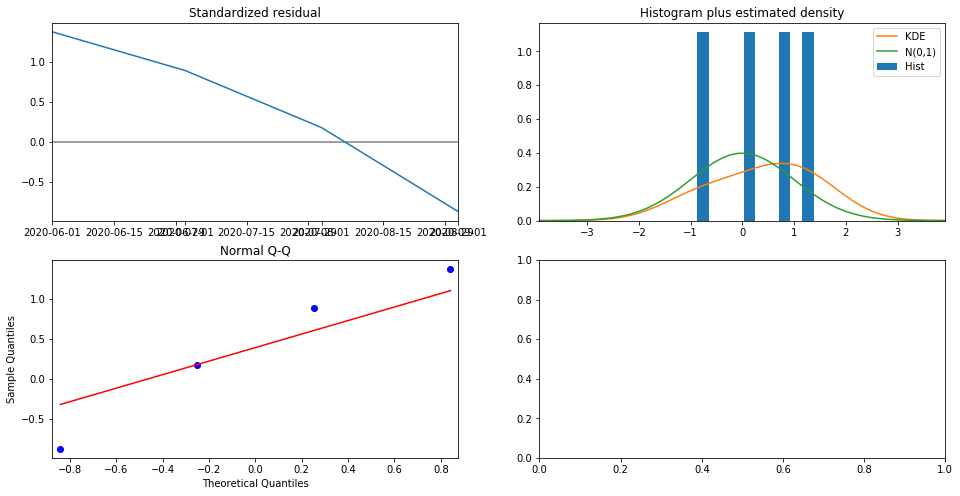

In [30]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2020-09-17'), dynamic=False)
pred_ci = pred.conf_int()

ax = confirmed_d['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed Cases')
plt.legend()
plt.show()

In [ ]:
confirmed_forecasted = pred.predicted_mean
confirmed_truth = confirmed_d['2020-09-17':]mse = ((confirmed_forecasted - confirmed_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()ax = confirmed_d.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed Cases')
plt.legend()
plt.show()